# New Baseline 

In [101]:
# General libraries.
import re
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
#from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import make_pipeline

from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianNoise
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy

import accelerate
import mkl

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline  

ModuleNotFoundError: No module named 'xgboost'

In [100]:
train_df = pd.read_json("../input/train.json")
test_df = pd.read_json("../input/test.json")

In [97]:
print(train_df.columns)

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')


# Visualization

Let us first visualize the data in various different ways, but before that we want to do some basic manipulations to the data

In [98]:
def categorical_average(variable, y, pred_0, feature_name):
    def calculate_average(sub1, sub2):
        s = pd.DataFrame(data = {
                                 variable: sub1.groupby(variable, as_index = False).count()[variable],                              
                                 'sumy': sub1.groupby(variable, as_index = False).sum()['y'],
                                 'avgY': sub1.groupby(variable, as_index = False).mean()['y'],
                                 'cnt': sub1.groupby(variable, as_index = False).count()['y']
                                 })
                                 
        tmp = sub2.merge(s.reset_index(), how='left', left_on=variable, right_on=variable) 
        del tmp['index']                       
        tmp.loc[pd.isnull(tmp['cnt']), 'cnt'] = 0.0
        tmp.loc[pd.isnull(tmp['cnt']), 'sumy'] = 0.0

        def compute_beta(row):
            cnt = row['cnt'] if row['cnt'] < 200 else float('inf')
            return 1.0 / (g + np.exp((cnt - k) / f))
            
        if lambda_val is not None:
            tmp['beta'] = lambda_val
        else:
            tmp['beta'] = tmp.apply(compute_beta, axis = 1)
            
        tmp['adj_avg'] = tmp.apply(lambda row: (1.0 - row['beta']) * row['avgY'] + row['beta'] * row['pred_0'],
                                   axis = 1)
                                   
        tmp.loc[pd.isnull(tmp['avgY']), 'avgY'] = tmp.loc[pd.isnull(tmp['avgY']), 'pred_0']
        tmp.loc[pd.isnull(tmp['adj_avg']), 'adj_avg'] = tmp.loc[pd.isnull(tmp['adj_avg']), 'pred_0']
        tmp['random'] = np.random.uniform(size = len(tmp))
        tmp['adj_avg'] = tmp.apply(lambda row: row['adj_avg'] *(1 + (row['random'] - 0.5) * r_k),
                                   axis = 1)
    
        return tmp['adj_avg'].ravel()
     
    #cv for training set 
    k_fold = StratifiedKFold(5)
    train_df[feature_name] = -999 
    for (train_index, cv_index) in k_fold.split(np.zeros(len(train_df)),
                                                train_df['interest_level'].ravel()):
        sub = pd.DataFrame(data = {variable: train_df[variable],
                                   'y': train_df[y],
                                   'pred_0': train_df[pred_0]})
            
        sub1 = sub.iloc[train_index]        
        sub2 = sub.iloc[cv_index]
        
        train_df.loc[cv_index, feature_name] = calculate_average(sub1, sub2)
    
    #for test set
    sub1 = pd.DataFrame(data = {variable: train_df[variable],
                                'y': train_df[y],
                                'pred_0': train_df[pred_0]})
    sub2 = pd.DataFrame(data = {variable: test_df[variable],
                                'y': test_df[y],
                                'pred_0': test_df[pred_0]})
    test_df.loc[:, feature_name] = calculate_average(sub1, sub2)                               

def transform_data(X):
    #add features    
    feat_sparse = feature_transform.transform(X["features"])
    vocabulary = feature_transform.vocabulary_
    del X['features']
    X1 = pd.DataFrame([ pd.Series(feat_sparse[i].toarray().ravel()) for i in np.arange(feat_sparse.shape[0]) ])
    X1.columns = list(sorted(vocabulary.keys()))
    X = pd.concat([X.reset_index(), X1.reset_index()], axis = 1)
    del X['index']
    
    X["num_photos"] = X["photos"].apply(len)
    X['created'] = pd.to_datetime(X["created"])
    X["num_description_words"] = X["description"].apply(lambda x: len(x.split(" ")))
    X['price_per_bed'] = X['price'] / X['bedrooms']    
    X['price_per_bath'] = X['price'] / X['bathrooms']
    X['price_per_room'] = X['price'] / (X['bathrooms'] + X['bedrooms'] )
    
    X['low'] = 0
    X.loc[X['interest_level'] == 0, 'low'] = 1
    X['medium'] = 0
    X.loc[X['interest_level'] == 1, 'medium'] = 1
    X['high'] = 0
    X.loc[X['interest_level'] == 2, 'high'] = 1
    
    X['display_address'] = X['display_address'].apply(lambda x: x.lower().strip())
    X['street_address'] = X['street_address'].apply(lambda x: x.lower().strip())
    
    X['pred0_low'] = low_count * 1.0 / train_size
    X['pred0_medium'] = medium_count * 1.0 / train_size
    X['pred0_high'] = high_count * 1.0 / train_size
    
    X.loc[X['manager_id'].isin(managers_with_one_lot['manager_id'].ravel()), 
          'manager_id'] = "-1"
    X.loc[X['building_id'].isin(buildings_with_one_lot['building_id'].ravel()), 
          'building_id'] = "-1"
    X.loc[X['display_address'].isin(addresses_with_one_lot['display_address'].ravel()), 
          'display_address'] = "-1"
          
    return X

def normalize_high_cardinality_data():
    high_cardinality = ["building_id", "manager_id"]
    for c in high_cardinality:
        categorical_average(c, "medium", "pred0_medium", c + "_mean_medium")
        categorical_average(c, "high", "pred0_high", c + "_mean_high")

def transform_categorical_data():
    categorical = ['building_id', 'manager_id', 
                   'display_address', 'street_address']
                   
    for f in categorical:
        encoder = LabelEncoder()
        encoder.fit(list(train_df[f]) + list(test_df[f])) 
        train_df[f] = encoder.transform(train_df[f].ravel())
        test_df[f] = encoder.transform(test_df[f].ravel())
                  

def remove_columns(X):
    columns = ["photos", "pred0_high", "pred0_low", "pred0_medium",
               "description", "low", "medium", "high", "created"]
    for c in columns:
        del X[c]


In [84]:
#add features
feature_transform = CountVectorizer(stop_words='english', max_features=150)
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
feature_transform.fit(list(train_df['features']) + list(test_df['features']))

train_size = len(train_df)
low_count = len(train_df[train_df['interest_level'] == 0])
medium_count = len(train_df[train_df['interest_level'] == 1])
high_count = len(train_df[train_df['interest_level'] == 2])

def find_objects_with_only_one_record(feature_name):
    temp = pd.concat([train_df[feature_name].reset_index(), 
                      test_df[feature_name].reset_index()])
    temp = temp.groupby(feature_name, as_index = False).count()
    return temp[temp['index'] == 1]

managers_with_one_lot = find_objects_with_only_one_record('manager_id')
buildings_with_one_lot = find_objects_with_only_one_record('building_id')
addresses_with_one_lot = find_objects_with_only_one_record('display_address')

lambda_val = None
k=5.0
f=1.0
r_k=0.01 
g = 1.0



In [85]:
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
train_df['interest_level'] = train_df['interest_level'].apply(lambda x: interest_level_map[x])
test_df['interest_level'] = -1


In [86]:

train_df["features"] = train_df["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
test_df["features"] = test_df["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
train_df.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')

In [87]:
print("Starting transformations")        
print(train_df.columns)
train_df = transform_data(train_df)    
test_df = transform_data(test_df) 
y = train_df['interest_level'].ravel()

print(train_df.columns)

print("Normalizing high cordiality data...")
normalize_high_cardinality_data()
transform_categorical_data()

remove_columns(train_df)
remove_columns(test_df)

print("Start fitting...")

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.02
param['max_depth'] = 4
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['seed'] = 321
param['nthread'] = 8
num_rounds = 2000

xgtrain = xgb.DMatrix(train_df, label=y)
clf = xgb.train(param, xgtrain, num_rounds)

print("Fitted")


Starting transformations
Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')
Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'interest_level', 'latitude', 'listing_id',
       'longitude',
       ...
       'num_photos', 'num_description_words', 'price_per_bed',
       'price_per_bath', 'price_per_room', 'low', 'medium', 'pred0_low',
       'pred0_medium', 'pred0_high'],
      dtype='object', length=174)
Normalizing high cordiality data...
Start fitting...


NameError: name 'xgb' is not defined

### Creating Neighborhoods
#### Outlier Removal

If you take a look to the location coordinates you'll notice a few outliers far away from NY city center. I'll start by excluding them using a recursive approach. At each iteration all the listings with |z-score|>3 are excluded. The removal algorithm stops once all the listings have |z-score|<3.

<bound method NDFrame.head of        bathrooms  bedrooms  building_id  display_address  latitude  \
0            1.5         3         2103            10443   40.7145   
1            1.0         2         5077             7525   40.7947   
2            1.0         1         5028            11824   40.7388   
3            1.0         1         1033             9118   40.7539   
4            1.0         4            1            13070   40.8241   
5            2.0         4         1425            13190   40.7429   
6            1.0         2         1517            12962   40.8012   
7            2.0         1           82               32   40.7427   
8            1.0         1         4301             9845   40.8234   
9            2.0         4            1             5131   40.7278   
10           1.0         0            1            13672   40.7769   
11           1.0         1            1            12726   40.8448   
12           1.0         2         2649             8081   4

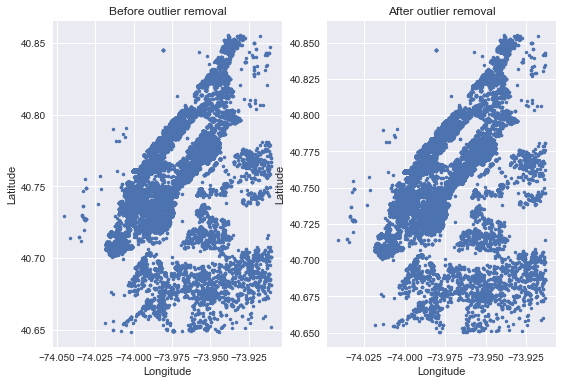

In [94]:
print(train_df.head)
# Show location coordinates before oulier removal
fig, ax = plt.subplots(1, 2, figsize=(9,6))
print('Length before removing ouliers', len(train_df))
ax[0].plot(train_df.longitude, train_df.latitude, '.');
ax[0].set_title('Before outlier removal');
ax[0].set_xlabel('Longitude');
ax[0].set_ylabel('Latitude');
# Outlier removal
for i in ['latitude', 'longitude']:
    while(1):
        x = train_df[i].median()
        ix = abs(train_df[i] - x) > 3*train_df[i].std()
        if ix.sum()==0: # no more outliers -> stop
            break
        train_df.loc[ix, i] = np.nan # exclude outliers
# Keep only non-outlier listings
train_df = train_df.loc[train_df[['latitude', 'longitude']].isnull().sum(1) == 0, :]
print('Length after removing ouliers', len(train_df))
# Show location coordinates after outlier removal
ax[1].plot(train_df.longitude, train_df.latitude, '.');
ax[1].set_title('After outlier removal');
ax[1].set_xlabel('Longitude');
ax[1].set_ylabel('Latitude');

### Neighborhoods

We use KMeans clustering based on the mean and standard deviation of latitude and longitude

<bound method NDFrame.head of        bathrooms  bedrooms  building_id  display_address  latitude  \
0            1.5         3         2103            10443   40.7145   
1            1.0         2         5077             7525   40.7947   
2            1.0         1         5028            11824   40.7388   
3            1.0         1         1033             9118   40.7539   
4            1.0         4            1            13070   40.8241   
5            2.0         4         1425            13190   40.7429   
6            1.0         2         1517            12962   40.8012   
7            2.0         1           82               32   40.7427   
8            1.0         1         4301             9845   40.8234   
9            2.0         4            1             5131   40.7278   
10           1.0         0            1            13672   40.7769   
11           1.0         1            1            12726   40.8448   
12           1.0         2         2649             8081   4

KeyError: "Columns not found: 'interest_level'"

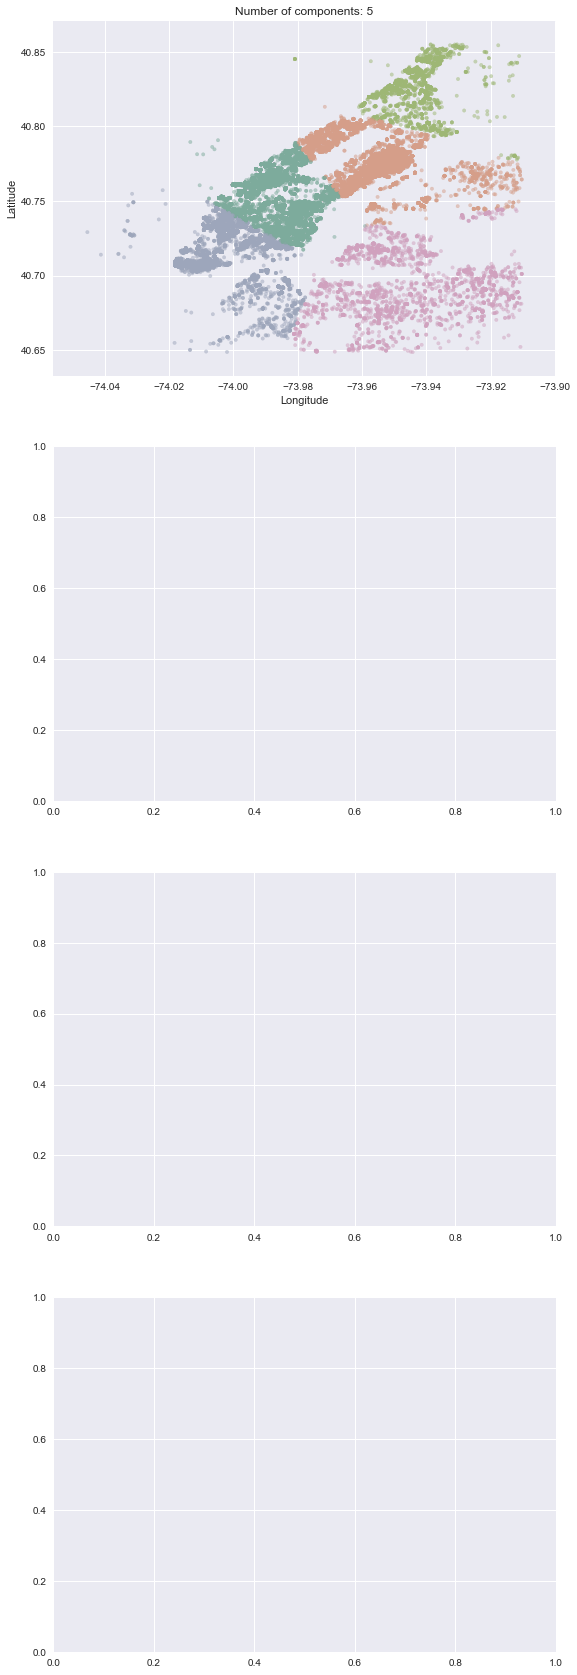

In [93]:
print(train_df.head)
fig, ax = plt.subplots(4,1,figsize=(9,30))
for ix, ncomp in enumerate([5, 10, 20, 40]):
    r = KMeans(ncomp, random_state=1)
    # Normalize (longitude, latitude) before K-means
    temp = train_df[['longitude', 'latitude']].copy()
    temp['longitude'] = (temp['longitude']-temp['longitude'].mean())/temp['longitude'].std()
    temp['latitude'] = (temp['latitude']-temp['latitude'].mean())/temp['latitude'].std()
    # Fit k-means and get labels
    r.fit(temp[['longitude', 'latitude']])
    train_df['labels'] = r.labels_
    # Plot results
    cols = sns.color_palette("Set2", n_colors=ncomp, desat=.5)
    cl = [cols[i] for i in r.labels_]
    area = 12
    ax[ix].scatter(train_df.longitude, train_df.latitude, s=area, c=cl, alpha=0.5);
    ax[ix].set_title('Number of components: ' + str(ncomp))
    ax[ix].set_xlabel('Longitude')
    ax[ix].set_ylabel('Latitude')
    # Show aggregated volume and interest at each neighborhood
    x = train_df.groupby('labels')[['longitude','latitude','interest_level']].mean().sort_values(['interest_level'])
    x = pd.concat([x, train_df['labels'].value_counts()], axis=1).sort_values(['interest_level'])
    cols = sns.color_palette("RdBu_r", ncomp)[::-1]
    for i in range(ncomp):
        props = dict(boxstyle='round', facecolor=cols[i], alpha=0.8)
        ax[ix].text(x.longitude.values[i], x.latitude.values[i], 
                str(np.array(np.round(x.response.values,2), '|S8')[i])+'\n'+str(np.array(x['labels'].values, '|S8')[i]), 
                fontsize=9, verticalalignment='center', horizontalalignment='center', bbox=props);

## Feature Engineering

In [48]:
def clean(s):
    x = s.replace("-", "")
    x = x.replace(" ", "")
    x = x.replace("twenty four hour", "24")
    x = x.replace("24/7", "24")
    x = x.replace("24hr", "24")
    x = x.replace("24-hour", "24")
    x = x.replace("24hour", "24")
    x = x.replace("24 hour", "24")
    x = x.replace("common", "cm")
    x = x.replace("concierge", "doorman")
    x = x.replace("bicycle", "bike")
    x = x.replace("private", "pv")
    x = x.replace("deco", "dc")
    x = x.replace("decorative", "dc")
    x = x.replace("onsite", "os")
    x = x.replace("outdoor", "od")
    x = x.replace("ss appliances", "stainless")
    return x

In [49]:
def feature_eng(dataframe):
    features = dataframe[["features"]]
    for feature in features.features:
        for feat in feature:
            feat = clean(feat)
        

In [29]:
features_train = train_df[["features"]].apply(
    lambda _: [list(map(str.strip, map(str.lower, x))) for x in _])

train_df[["features"]] = features_train[["features"]]

features_test = test_df[["features"]].apply(
    lambda _: [list(map(str.strip, map(str.lower, x))) for x in _])

test_df[["features"]] = features_test[["features"]]

feature_eng(train_df)
feature_eng(test_df)

## Data Engineering

### Following functions will help us parse the date/time fields

In [ ]:
def parse_time(x):
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year

In [ ]:
''''bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address''''

def parse_data(df,logodds,logoddsPA,togroup=["Address"]):
    
    feature_list=df.columns.tolist()
    
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Category" in feature_list:
        feature_list.remove("Category")
    if "Id" in feature_list:
        feature_list.remove("Id")
        
    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    
    print "Creating address features"
    
    address_features=cleanData[togroup].apply(lambda x: pd.Series(getLogOdds(tuple(x),logodds)),axis=1)
    print(address_features.shape)
    address_features.columns=["logodds"+str(x) for x in range(len(address_features.columns))]
    
    print "Parsing dates"
    cleanData["Time"], cleanData["Day"], cleanData["Month"], cleanData["Year"]=zip(*cleanData["Dates"].apply(parse_time))
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print "Creating one-hot variables"
    dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')
    
    cleanData["IsIntersection"]=cleanData["Address"].apply(lambda x: 1 if "/" in x else 0)
    cleanData["logoddsPA"]=cleanData["Address"].apply(lambda x: logoddsPA[x])
    
    print "droping processed columns"
    cleanData=cleanData.drop("PdDistrict",axis=1)
    cleanData=cleanData.drop("DayOfWeek",axis=1)
    cleanData=cleanData.drop("Address",axis=1)
    cleanData=cleanData.drop("Dates",axis=1)
    cleanData=cleanData.drop("Street1",axis=1)
    cleanData=cleanData.drop("Street2",axis=1)

    feature_list=cleanData.columns.tolist()
    
    print "joining one-hot features"
    features = cleanData[feature_list].join(dummy_ranks_PD.ix[:,:]).join(dummy_ranks_DAY.ix[:,:]).join(address_features.ix[:,:])
    
    print "creating new features"
    features["IsDup"]=pd.Series(features.duplicated()|features.duplicated(take_last=True)).apply(int)
    features["Awake"]=features["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    features["Summer"], features["Fall"], features["Winter"], features["Spring"]=zip(*features["Month"].apply(get_season))
    if "Category" in df.columns:
        labels = df["Category"].astype('category')
#         label_names=labels.unique()
#         labels=labels.cat.rename_categories(range(len(label_names)))
    else:
        labels=None
    return features,labels

In [ ]:
def prepare_submission(model):
    xgtest = xgb.DMatrix(test_df)
    preds = model.predict(xgtest)    
    sub = pd.DataFrame(data = {'listing_id': test_df['listing_id'].ravel()})
    sub['low'] = preds[:, 0]
    sub['medium'] = preds[:, 1]
    sub['high'] = preds[:, 2]
    sub.to_csv("submission.csv", index = False, header = True)

prepare_submission(clf)